## Ensemble Learning Algorithms and Their Comparisons

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Ensemble Learning

**Ensemble Learning** is the method of combining multiple Machine Learning models (can be called **weak learners**) to create a single, powerful predictive model. It is like, one model can give predictions with some accuracy, precision and recall; but combining the results from multiple models with different metrics, will increase the overall performance. It is analogy to asking one friend and taking his answer as a true answer, and asking to many friends and taking the mean of their predictions (for regression tasks) or taking the most voted choice (classification algorithms). 

**Main Ensemble methods**: 
1. **Bagging (Bootstrap Algorithms)**: combining multiple models parallely. This reduces the variance. Examples are *Random Forests*, *Bagging Classifiers with SVM*, *ExtraTrees (Extremely Randomized Trees)*.
2. **Boosting**: combining multiple models sequentially, so the next models will work on the results of previous models. Examples are *AdaBoost*,*XGBoost*, *CatBoost*, *LightGBM*.

We will practice 3 different algorithms from *Bagging* methods and 4 algorithms from *Boosting* methods. I will compare the results based on the following performance metrics: Accuracy, precision, recall, ROC curve, AUC curve, ROC & AUC score and Gini score.

## Data Preparation

### Data Reading

---
Before building the models and comparing them, firstly, let's clean the dataset and make it ready for the modelling. The dataset is the loan_prediction.csv. It has the following columns:
1. Loan_ID - Unique Loan ID
2. Gender - male/female
3. married - applicant married (yes or no)
4. dependents - number of dependents
5. education - applicant education (graduate / under graduate)
6. self_employed - self-employed (yes or no)
7. ApplicantIncome - applicant income
8. CoapplicantIncome - co-applicant income
9. LoanAmount -  loan amount in thousands
10. Loan_Amount_Term - term of loan in months
11. Credit_History - credit history meets guidelines
12. Property_Area - Urban/Semi urban/ Rural
13. Loan_Status - Loan approved (yes or no) [Target]

In [31]:
data = pd.read_csv("loan_prediction.csv")
df = data.copy()
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


### Data Cleaning

#### Column names

Check the column names and lowercase them. Delete spaces before and after the column names using **split()** method.

In [32]:
df.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [33]:
import re
df.columns = [re.sub(r'([a-z])([A-Z])', r'\1_\2', col) for col in df.columns]
df.columns = df.columns.str.lower()

In [34]:
df.columns

Index(['loan_id', 'gender', 'married', 'dependents', 'education',
       'self_employed', 'applicant_income', 'coapplicant_income',
       'loan_amount', 'loan_amount_term', 'credit_history', 'property_area',
       'loan_status'],
      dtype='object')

In [35]:
df.columns

Index(['loan_id', 'gender', 'married', 'dependents', 'education',
       'self_employed', 'applicant_income', 'coapplicant_income',
       'loan_amount', 'loan_amount_term', 'credit_history', 'property_area',
       'loan_status'],
      dtype='object')

#### Data types

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   loan_id             614 non-null    object 
 1   gender              601 non-null    object 
 2   married             611 non-null    object 
 3   dependents          599 non-null    object 
 4   education           614 non-null    object 
 5   self_employed       582 non-null    object 
 6   applicant_income    614 non-null    int64  
 7   coapplicant_income  614 non-null    float64
 8   loan_amount         592 non-null    float64
 9   loan_amount_term    600 non-null    float64
 10  credit_history      564 non-null    float64
 11  property_area       614 non-null    object 
 12  loan_status         614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


Data types are correctly defined. Therefore, no need to change data types.

#### Missing values

In [37]:
index = df.columns
msng_data = [df[col].isnull().sum() for col in df.columns]

missing_values = pd.DataFrame(data=msng_data,index=index, columns = ["n_of_missing"])

In [38]:
missing_values["% of total"] = [round(df[col].isnull().sum()/df.shape[0]*100,2) for col in df.columns]
missing_values["data_type"] = [df[col].dtype for col in df.columns]
missing_values

,n_of_missing,% of total,data_type
loan_id,0,0.00,object
gender,13,2.12,object
married,3,0.49,object
dependents,15,2.44,object
education,0,0.00,object
self_employed,32,5.21,object
applicant_income,0,0.00,int64
coapplicant_income,0,0.00,float64
loan_amount,22,3.58,float64
loan_amount_term,14,2.28,float64


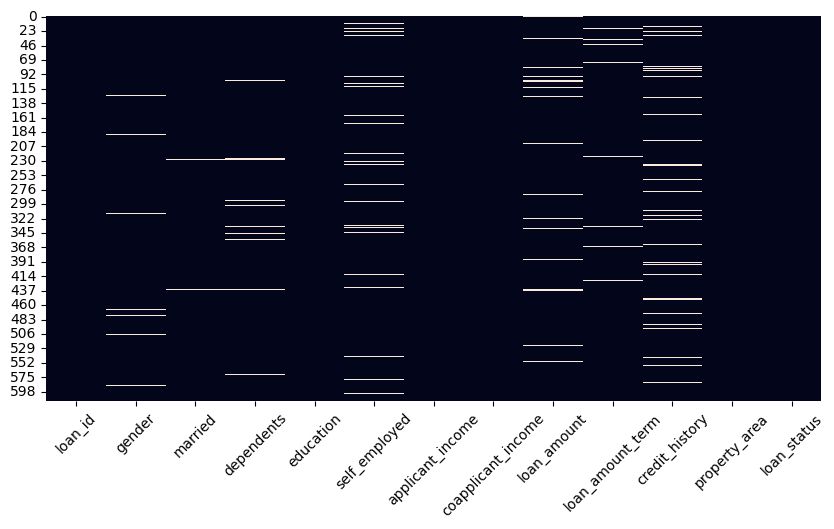

In [39]:
# visualize the missing values
plt.figure(figsize=(10,5))
sns.heatmap(df.isnull(), cbar=False)
plt.xticks(rotation=45)
plt.show()

<font size = 5> 

In numerical variables, I will impute the mean to the missing values. In categorical variables I will impute the mode value into the missing values.

</font>

In [40]:
numeric_msng_cols = df.select_dtypes(include='number').isnull().sum()
numeric_msng_cols = numeric_msng_cols[numeric_msng_cols>0].index.to_list()
numeric_msng_cols

['loan_amount', 'loan_amount_term', 'credit_history']

In [41]:
for col in numeric_msng_cols:
    df[col] = df[col].fillna(df[col].mean())

In [42]:
# Categorical variables
categoric_msng_cols = df.select_dtypes(include='object').isnull().sum()
categoric_msng_cols = categoric_msng_cols[categoric_msng_cols>0].index.to_list()

In [43]:
categoric_msng_cols

['gender', 'married', 'dependents', 'self_employed']

In [44]:
for col in categoric_msng_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

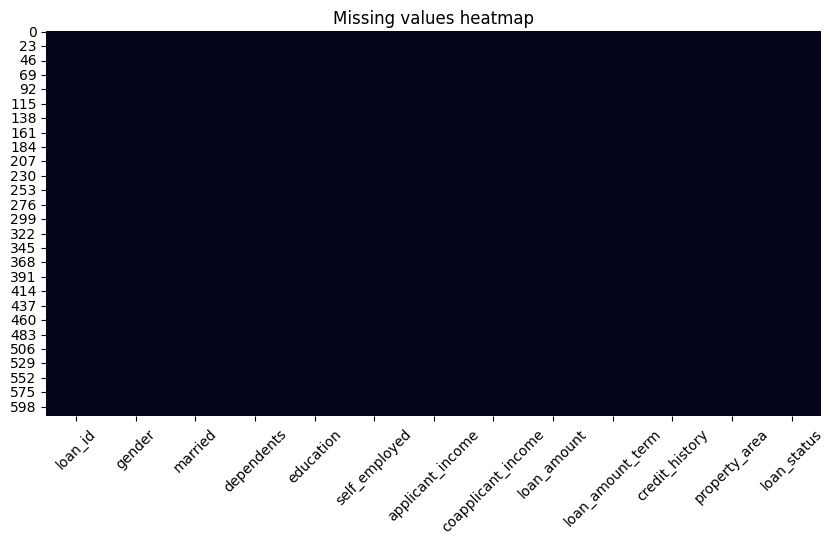

In [45]:
# Check the missing values in the dataset
plt.figure(figsize=(10,5))
sns.heatmap(df.isnull(), cbar=False)
plt.xticks(rotation=45)
plt.title("Missing values heatmap")
plt.show()

#### Duplicated values

In [46]:
df.duplicated().sum()

np.int64(0)

There is not any duplicated values in the dataset.

#### Outliers

Outliers exist in numeric columns. Firstly, let's observe the distributions in the numeric columns.

In [47]:
numeric_cols = df.select_dtypes(include='number').columns
numeric_cols

Index(['applicant_income', 'coapplicant_income', 'loan_amount',
       'loan_amount_term', 'credit_history'],
      dtype='object')

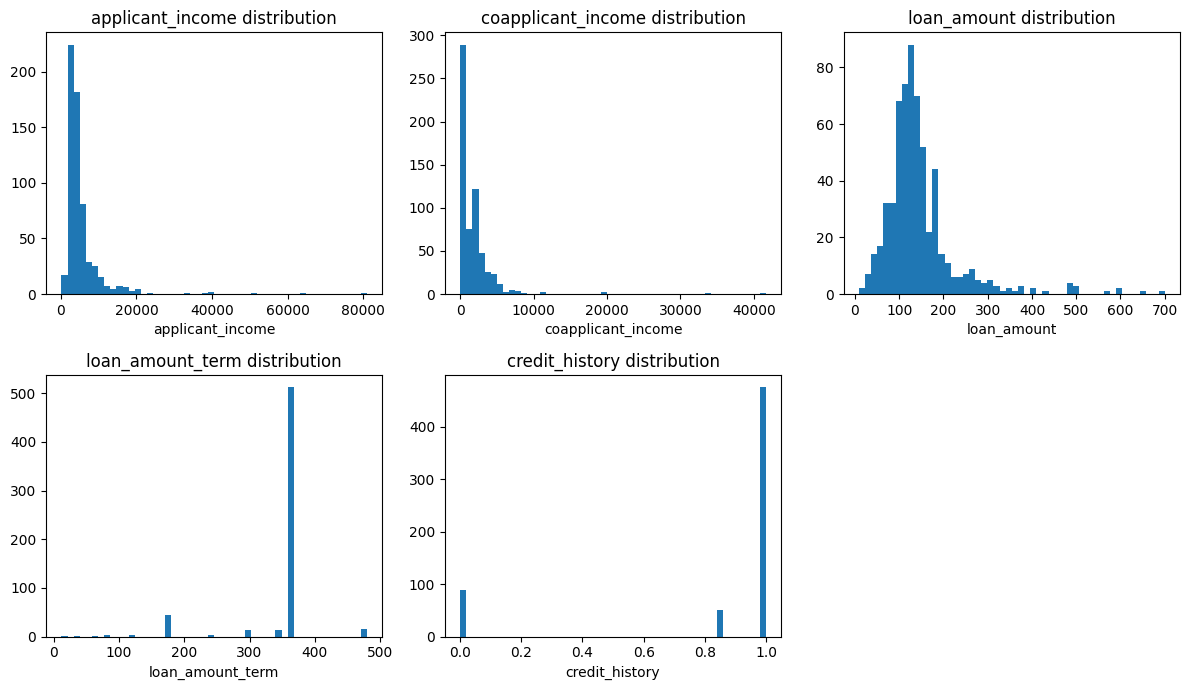

In [48]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,7))
axes = axes.flatten()

for i,col in enumerate(numeric_cols):
    axes[i].hist(df[col],bins=50)
    axes[i].set_title(f'{col} distribution')
    axes[i].set_xlabel(f'{col}')

for i in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

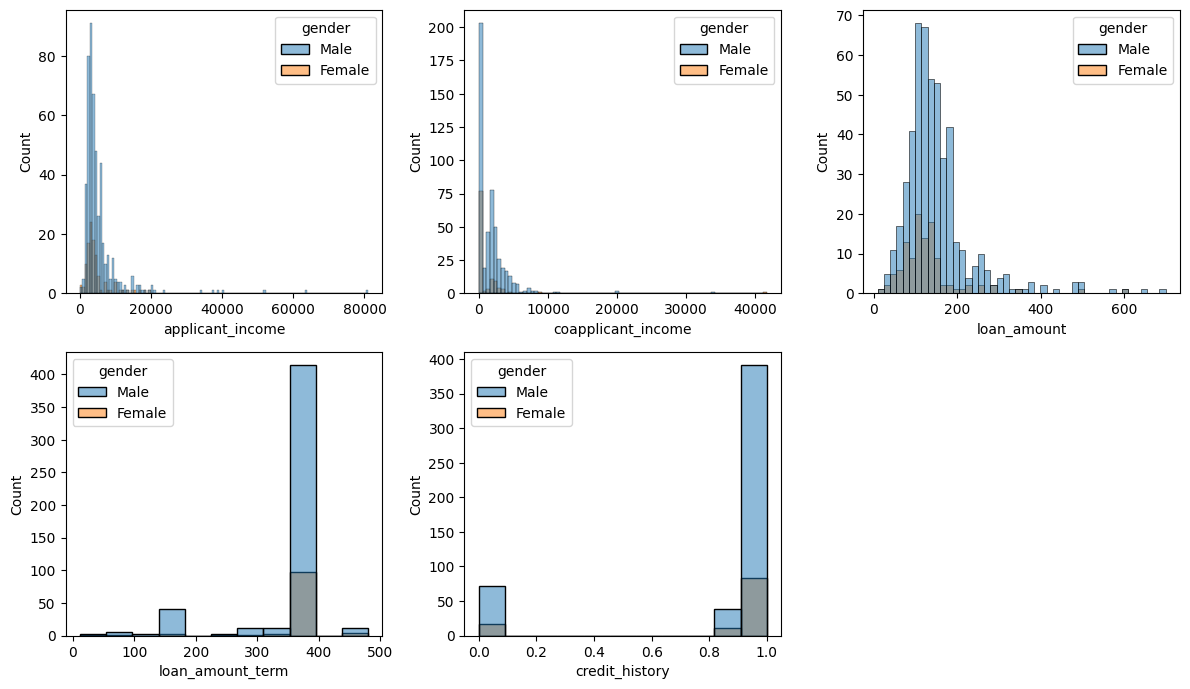

In [49]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,7))
axes = axes.flatten()

for i,col in enumerate(numeric_cols):
    sns.histplot(data=df, x = col, ax = axes[i], hue="gender")

for i in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

As we can see from the distributions, there are some outliers inside the numeric columns. Let's visualize these with box-plots.

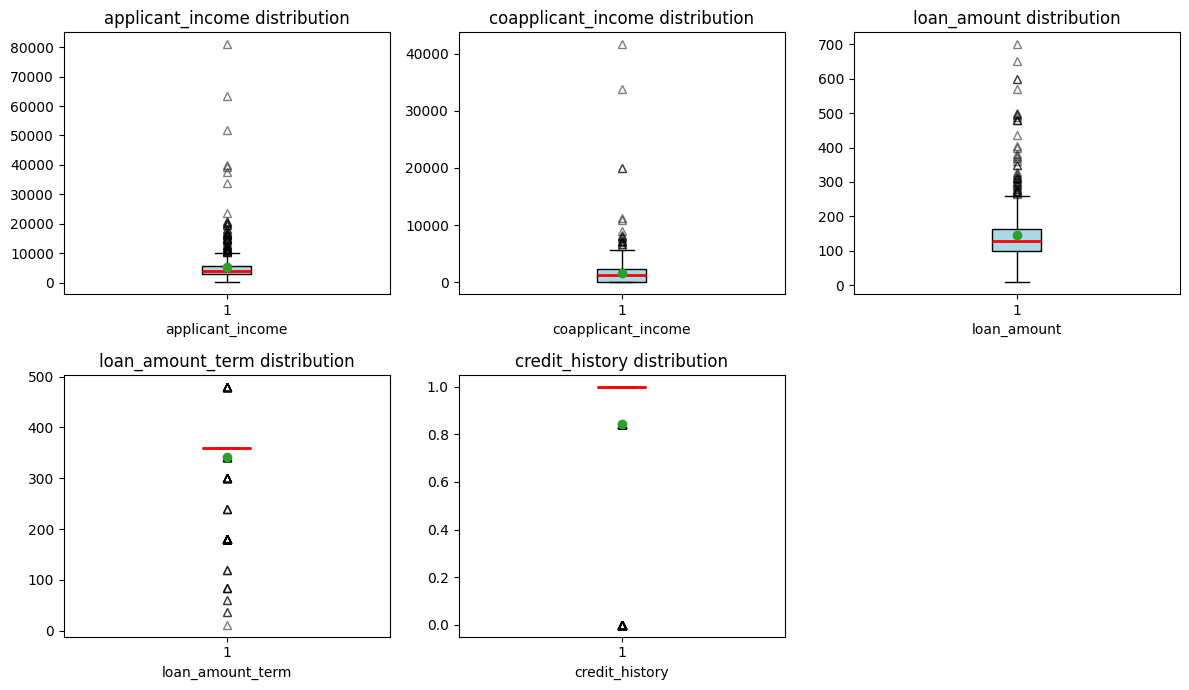

In [50]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,7))
axes = axes.flatten()

for i,col in enumerate(numeric_cols):
    axes[i].boxplot(df[col], patch_artist = True, showmeans=True, showcaps=True, showbox=True,
                   showfliers=True, boxprops=dict(facecolor="lightblue", color="black"),
                   medianprops=dict(color="red", linewidth=2), 
                    flierprops=dict(marker='^',color='orange',alpha=0.5),
                    meanprops=dict(marker='o',color='green')
                   )
    axes[i].set_title(f'{col} distribution')
    axes[i].set_xlabel(f'{col}')

for i in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

I will remove outliers from the applicant_income, coapplicant_income and loan_amount columns.

In [51]:
def remove_outliers(col):
    Q1 = np.percentile(df[col],25)
    Q3 = np.percentile(df[col],75)
    IQR = Q3 - Q1
    lower_bound = Q1-1.5*IQR
    upper_bound = Q3+1.5*IQR
    return lower_bound, upper_bound

In [52]:
# remove outliers 
numeric_cols = ['applicant_income','coapplicant_income','loan_amount']
for col in numeric_cols:
    lower, upper = remove_outliers(col)
    df[col] = np.clip(a=df[col], a_min=lower, a_max=upper)

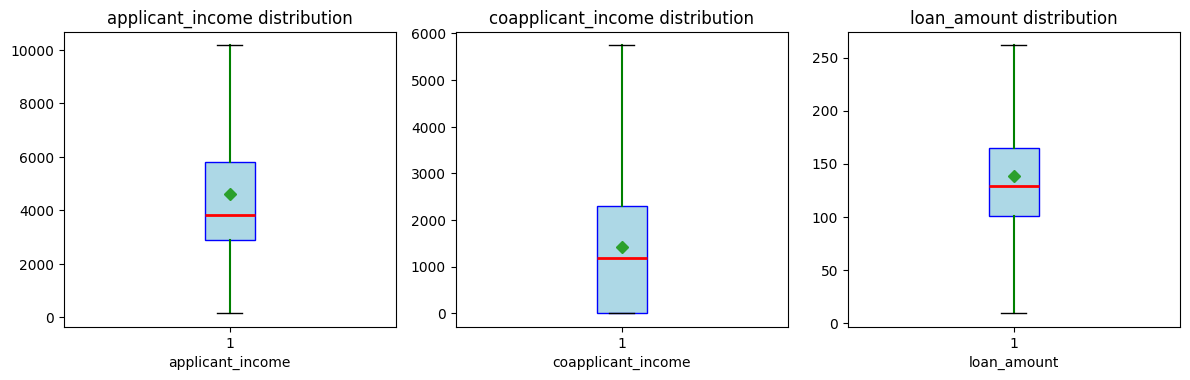

In [53]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,7))
axes = axes.flatten()

for i,col in enumerate(numeric_cols):
    axes[i].boxplot(df[col], patch_artist=True, showbox=True,showmeans=True,showfliers=True,
                    boxprops=dict(facecolor="lightblue", color="blue"),
                   medianprops=dict(color="red", linewidth=2),
                   whiskerprops=dict(color="green", linewidth=1.5),
                   flierprops=dict(marker='o', color='orange', alpha=0.6),
                   meanprops=dict(marker='D', color='black'))
    axes[i].set_title(f'{col} distribution')
    axes[i].set_xlabel(f'{col}')

for i in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

#### Scaling

Scale the numeric variables. Use StandardScaler (mean=0 and std=1). 

In [182]:
from sklearn.preprocessing import StandardScaler

In [183]:
numeric_cols = df.select_dtypes(include='number').columns
numeric_cols

Index(['applicant_income', 'coapplicant_income', 'loan_amount',
       'loan_amount_term', 'credit_history'],
      dtype='object')

In [184]:
scaler = StandardScaler()

In [185]:
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [186]:
df.head()

,loan_id,gender,married,dependents,education,self_employed,applicant_income,coapplicant_income,loan_amount,loan_amount_term,credit_history,property_area,loan_status
0,LP001002,Male,No,0,Graduate,No,0.497164,-0.874587,0.150494,0.279851,0.45164,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,-0.013767,0.054395,-0.179896,0.279851,0.45164,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,-0.652632,-0.874587,-1.292433,0.279851,0.45164,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,-0.820924,0.578025,-0.323449,0.279851,0.45164,Urban,Y
4,LP001008,Male,No,0,Graduate,No,0.558104,-0.874587,0.053377,0.279851,0.45164,Urban,Y


### Diagnostic Analysis

#### Numeric vs Numeric variables

In [187]:
mask = np.triu(np.ones_like(df[numeric_cols].corr()))

<Axes: >

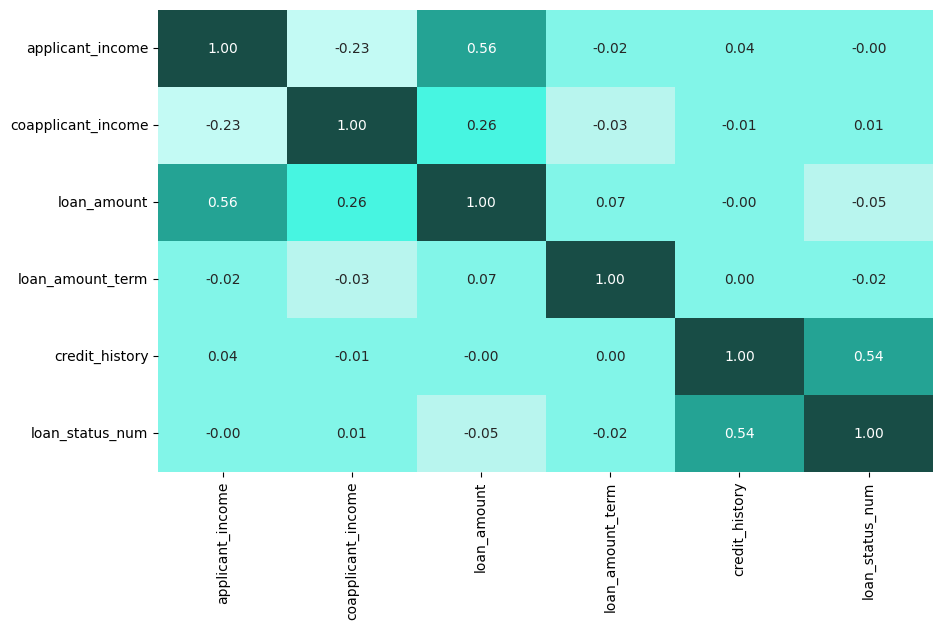

In [214]:
plt.figure(figsize=(10,6))
sns.heatmap(df[numeric_cols].corr(),cbar=False,cmap = ['#c3faf4','#b8f5ee','#82f5e8','#6deddf','#47f5e1','#24e3cd','#15bfac','#24a394','#2c8f83',
                                                      '#197368','#0b574e','#184d46'],
           annot=True, fmt="1.2f")

In [190]:
loan_map = {"Y":1, "N":0}

df['loan_status_num'] = df['loan_status'].map(loan_map)

In [192]:
df['loan_status_num'].dtype

dtype('int64')

In [199]:
numeric_cols=df.select_dtypes(include='number').columns

<Axes: >

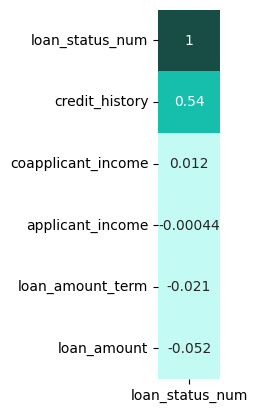

In [217]:
corr = df[numeric_cols].corr(method='pearson')[['loan_status_num']]
corr = corr.sort_values(by='loan_status_num',ascending=False)
sns.heatmap(corr,square=True,cbar=False, annot=True, 
           cmap = ['#c3faf4','#b8f5ee','#82f5e8','#6deddf','#47f5e1','#24e3cd','#15bfac','#24a394','#2c8f83',
                                                      '#197368','#0b574e','#184d46'])

From the results, we can say that there is a correlation between credit_history and loan_status. But remaining variables, do not have strong correlation. However, don't forget that this correlation is not reliable in unbalanced data. Also, pearson correlation captures linear relationships between the variables. If there is a non-linear correlation between variables, we can not detect them using simply corr() method.

<Axes: >

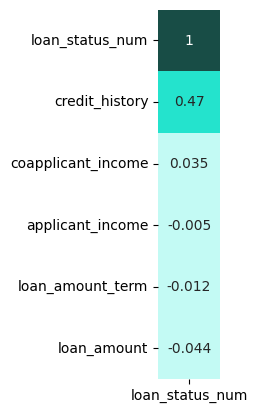

In [221]:
corr = df[numeric_cols].corr(method='spearman')[['loan_status_num']]
corr = corr.sort_values(by='loan_status_num',ascending=False)
sns.heatmap(corr,square=True,cbar=False, annot=True, 
           cmap = ['#c3faf4','#b8f5ee','#82f5e8','#6deddf','#47f5e1','#24e3cd','#15bfac','#24a394','#2c8f83',
                                                      '#197368','#0b574e','#184d46'])

In [219]:
df['loan_status'].value_counts()

loan_status
Y    422
N    192
Name: count, dtype: int64

For better observations, lets use categoric target variable *loan_status* (Y/N) and the numeric columns. To see the whether there is a relationship or not. 

#### Numeric vs Categoric variables

In [222]:
from scipy.stats import f_oneway

In [272]:
anova_results = {}
numeric_cols = df.select_dtypes(include='number').columns[:-1] # dont take loan_status_num

In [273]:
numeric_cols

Index(['applicant_income', 'coapplicant_income', 'loan_amount',
       'loan_amount_term', 'credit_history'],
      dtype='object')

In [274]:
for col in numeric_cols:
    group_yes = df[df['loan_status']=="Y"][col]
    group_no = df[df['loan_status']=="N"][col]

    f_stat, p_value = f_oneway(group_yes, group_no)

    anova_results[col] = [f_stat, p_value]    

In [275]:
anova_results = pd.DataFrame(anova_results, index = ['f_stat', 'p_value'])

In [276]:
anova_results = anova_results.T

In [277]:
anova_results = anova_results.sort_values(by='f_stat', ascending=False)

In [278]:
anova_results

,f_stat,p_value
credit_history,252.555883,7.263784e-48
loan_amount,1.662530,1.977491e-01
loan_amount_term,0.269339,6.039634e-01
coapplicant_income,0.087889,7.669789e-01
applicant_income,0.000120,9.912769e-01


According to the ANOVA test, we can confidently tell that the main predictor feature is **credit_history** in our dataset. Because it has quite large f_statistics and also it is significante because p-value is less than 0.005. Remaining variables don't explain the data too much, because there is not significant different between loan status 'Yes' and 'No'. Hence, our main feature to predict the target value is 'credit_history'. 

#### Categoric vs Categoric variables

<font size=5>

In order to find whether there is a strong relationship between categorical variables and target variable (loan_status), we should use **Chi-square test**. However, it doesn't tell how strong is this relationship. To visualize this strength, we need to use Cramers V rule. So, here we will apply Chi-square test to find correlated variables and then I will use Cramer's V rule for visualizing the strength.


</font>

<font size = 5> <b> Chi-square test </b> </font>

In [308]:
from scipy.stats import chi2_contingency

categoric_cols = df.select_dtypes(include='object').columns[1:-1]

chi_results = {}

for col in categoric_cols:
    table = pd.crosstab(df[col], df['loan_status'])
    chi2, p, d_, e_ = chi2_contingency(table)

    chi_results[col] = [chi2, p]

chi_df = pd.DataFrame(chi_results, index = ['chi2', 'p_value'])
chi_df = chi_df.T
chi_df


,chi2,p_value
gender,0.110879,0.739146
married,4.731876,0.029609
dependents,3.151399,0.368866
education,4.091490,0.043100
self_employed,0.000000,1.000000
property_area,12.297623,0.002136


According to the Chi-square results, we can tell that *property_area*,*married* and *education* variables has significant relationship between the target variable.

<font size = 5> <b> Cramers V rule </b></font>

Formula for Cramers V rule: 
$$V = \sqrt{ \frac {X^2} {n*(k-1)}} $$

Where,

* $X^2$ = Chi-square statistics
* $n$ = total number of observations
* $k$ = min(#rows, #cols)


In [309]:
def cramers_v(cross_table):
    chi2, p, d_, e_ = chi2_contingency(cross_table)
    n = cross_table.sum().sum()
    k = min(cross_table.shape) - 1
    return np.sqrt(chi2/(n*k)), p

In [310]:
cramerv_values = {}
for col in categoric_cols:
    table = pd.crosstab(df[col], df['loan_status'])
    v,p = cramers_v(table)
    cramerv_values[col] = [v]
cramerv_df = pd.DataFrame(cramerv_values,index=['cramers_v'])
cramerv_df = cramerv_df.T
cramerv_df

,cramers_v
gender,0.013438
married,0.087787
dependents,0.071642
education,0.081631
self_employed,0.000000
property_area,0.141523


In [311]:
diagn_results = pd.concat([chi_df, cramerv_df], axis=1)
diagn_results = diagn_results.sort_values(by=['p_value'])
diagn_results

,chi2,p_value,cramers_v
property_area,12.297623,0.002136,0.141523
married,4.731876,0.029609,0.087787
education,4.091490,0.043100,0.081631
dependents,3.151399,0.368866,0.071642
gender,0.110879,0.739146,0.013438
self_employed,0.000000,1.000000,0.000000


**Interpretations:**

Property area matters most (though still only weak effect) → type of property area is associated with loan approval.

Marital status and education show statistical significance but practical effect size is tiny (weak predictors).

Gender, dependents, and self_employed → no meaningful relationship with loan approval.

### Encode Categorical variables

In [322]:
df.head()

,gender,married,dependents,education,self_employed,applicant_income,coapplicant_income,loan_amount,loan_amount_term,credit_history,property_area,loan_status,loan_status_num
0,Male,No,0,Graduate,No,0.497164,-0.874587,0.150494,0.279851,0.45164,Urban,Y,1
1,Male,Yes,1,Graduate,No,-0.013767,0.054395,-0.179896,0.279851,0.45164,Rural,N,0
2,Male,Yes,0,Graduate,Yes,-0.652632,-0.874587,-1.292433,0.279851,0.45164,Urban,Y,1
3,Male,Yes,0,Not Graduate,No,-0.820924,0.578025,-0.323449,0.279851,0.45164,Urban,Y,1
4,Male,No,0,Graduate,No,0.558104,-0.874587,0.053377,0.279851,0.45164,Urban,Y,1


In [321]:
df.drop(['loan_id'],axis=1,inplace=True)

In [329]:
categoric_cols = df.select_dtypes(include='object').columns[:-1]

In [330]:
categoric_cols

Index(['gender', 'married', 'dependents', 'education', 'self_employed',
       'property_area'],
      dtype='object')

In [332]:
df_dummies = pd.get_dummies(df, columns=categoric_cols, drop_first=True,dtype=int)
df_dummies.head()

,applicant_income,coapplicant_income,loan_amount,loan_amount_term,credit_history,loan_status,loan_status_num,gender_Male,married_Yes,dependents_1,dependents_2,dependents_3+,education_Not Graduate,self_employed_Yes,property_area_Semiurban,property_area_Urban
0,0.497164,-0.874587,0.150494,0.279851,0.45164,Y,1,1,0,0,0,0,0,0,0,1
1,-0.013767,0.054395,-0.179896,0.279851,0.45164,N,0,1,1,1,0,0,0,0,0,0
2,-0.652632,-0.874587,-1.292433,0.279851,0.45164,Y,1,1,1,0,0,0,0,1,0,1
3,-0.820924,0.578025,-0.323449,0.279851,0.45164,Y,1,1,1,0,0,0,1,0,0,1
4,0.558104,-0.874587,0.053377,0.279851,0.45164,Y,1,1,0,0,0,0,0,0,0,1


In [334]:
df_dummies.columns

Index(['applicant_income', 'coapplicant_income', 'loan_amount',
       'loan_amount_term', 'credit_history', 'loan_status', 'loan_status_num',
       'gender_Male', 'married_Yes', 'dependents_1', 'dependents_2',
       'dependents_3+', 'education_Not Graduate', 'self_employed_Yes',
       'property_area_Semiurban', 'property_area_Urban'],
      dtype='object')

## Model Building

In [312]:
df.columns

Index(['loan_id', 'gender', 'married', 'dependents', 'education',
       'self_employed', 'applicant_income', 'coapplicant_income',
       'loan_amount', 'loan_amount_term', 'credit_history', 'property_area',
       'loan_status', 'loan_status_num'],
      dtype='object')

### Train-test split

In [340]:
X = df_dummies.drop(['loan_status','loan_status_num'],axis=1)
y = df_dummies['loan_status_num']

In [336]:
from sklearn.model_selection import train_test_split

In [341]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                            random_state=42,
                                            test_size=0.3, shuffle=True)

### Build model prediction functions

In [343]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, auc

In [359]:
model_results = {} # accuracy, precision, recall, roc, gini
results_for_plot = {}

In [360]:
def get_results(X_train, X_test, y_train, y_test, model, model_name):
    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]

    scores = {}
    plot_scores = {}
   
    # Evaluation metrics
    scores[model_name] = [
                        accuracy_score(y_test, y_pred),
                        precision_score(y_test, y_pred),
                        recall_score(y_test, y_pred),
                        roc_auc_score(y_test, y_prob)
                        ]

    # Metrics for plot
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plot_scores[model_name] = [fpr, tpr]

    # Return the results
    return scores, plot_scores

### Bagging Algorithms

In [387]:
# Random Forest
model_results, results_for_plot = get_results(X_train, X_test, y_train, y_test, 
                                              RandomForestClassifier(), "Random Forest" )

In [388]:
final_scores = pd.DataFrame(data=model_results,
                             index = ['Accuracy','Precision','Recall','ROC&AUC'])

In [389]:
final_scores

,Random Forest
Accuracy,0.783784
Precision,0.763158
Recall,0.966667
ROC&AUC,0.790385


In [391]:
final_plot_scores = []
final_plot_scores.append(results_for_plot)

In [398]:
# Bagging SVM Classifier
model_results, results_for_plot = get_results(X_train, X_test, y_train, y_test, 
                                              BaggingClassifier(estimator=SVC(probability=True),
                                                               n_estimators=50, random_state=111),
                                              "Bagging SVM" )

In [399]:
for model, values in model_results.items():
    final_scores[model] = values

In [400]:
final_scores

,Random Forest,Bagging SVM
Accuracy,0.783784,0.789189
Precision,0.763158,0.761290
Recall,0.966667,0.983333
ROC&AUC,0.790385,0.790641


In [401]:
final_plot_scores.append(results_for_plot)                   

In [403]:
# ExtraaTrees Bagging Classifier
model_results, results_for_plot = get_results(X_train, X_test, y_train, y_test, 
                                              ExtraTreesClassifier(random_state=111),
                                              "ExtraTree Bagging" )

In [404]:
for model, values in model_results.items():
    final_scores[model] = values
final_scores

,Random Forest,Bagging SVM,ExtraTree Bagging
Accuracy,0.783784,0.789189,0.762162
Precision,0.763158,0.761290,0.763889
Recall,0.966667,0.983333,0.916667
ROC&AUC,0.790385,0.790641,0.759359


In [405]:
final_plot_scores.append(results_for_plot) 

### Boosting Algorithms

In [409]:
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier

In [410]:
# Adaboost classifier
model_results, results_for_plot = get_results(X_train, X_test, y_train, y_test, 
    AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2,random_state=42),
                      n_estimators=50,random_state=42), "AdaBoost")

In [411]:
for model, values in model_results.items():
    final_scores[model] = values
final_scores

,Random Forest,Bagging SVM,ExtraTree Bagging,AdaBoost
Accuracy,0.783784,0.789189,0.762162,0.772973
Precision,0.763158,0.761290,0.763889,0.753247
Recall,0.966667,0.983333,0.916667,0.966667
ROC&AUC,0.790385,0.790641,0.759359,0.739808


In [412]:
final_plot_scores.append(results_for_plot) 
final_plot_scores

[{'Random Forest': [array([0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.01538462, 0.04615385, 0.04615385,
          0.09230769, 0.09230769, 0.09230769, 0.09230769, 0.09230769,
          0.10769231, 0.10769231, 0.15384615, 0.16923077, 0.2       ,
          0.23076923, 0.23076923, 0.23076923, 0.24615385, 0.24615385,
          0.24615385, 0.24615385, 0.24615385, 0.26153846, 0.26153846,
          0.27692308, 0.27692308, 0.27692308, 0.27692308, 0.29230769,
          0.32307692, 0.33846154, 0.36923077, 0.36923077, 0.38461538,
          0.38461538, 0.4       , 0.46153846, 0.49230769, 0.50769231,
          0.50769231, 0.52307692, 0.53846154, 0.53846154, 0.55384615,
          0.55384615, 0.56923077, 0.56923077, 0.61538462, 0.61538462,
          0.66153846, 0.69230769, 0.70769231, 0.76923077, 0.76923077,
          0.78461538, 0.83076923, 0.84615385, 0.89230769, 0.93846154,
          1.        ]),
   array([0.        , 0.00833333, 0.025     , 0.0

In [413]:
# XGBoost Classifier
model_results, results_for_plot = get_results(X_train, X_test, y_train, y_test, 
    XGBClassifier(n_estimators=100,random_state=42), "XGBoost")

In [414]:
for model, values in model_results.items():
    final_scores[model] = values
final_scores

,Random Forest,Bagging SVM,ExtraTree Bagging,AdaBoost,XGBoost
Accuracy,0.783784,0.789189,0.762162,0.772973,0.740541
Precision,0.763158,0.761290,0.763889,0.753247,0.750000
Recall,0.966667,0.983333,0.916667,0.966667,0.900000
ROC&AUC,0.790385,0.790641,0.759359,0.739808,0.768718


In [415]:
final_plot_scores.append(results_for_plot) 

In [416]:
# CatBoost Classifier
model_results, results_for_plot = get_results(X_train, X_test, y_train, y_test, 
    CatBoostClassifier(), "CatBoost")

Learning rate set to 0.007178
0:	learn: 0.6894055	total: 154ms	remaining: 2m 33s
1:	learn: 0.6857082	total: 159ms	remaining: 1m 19s
2:	learn: 0.6811920	total: 164ms	remaining: 54.4s
3:	learn: 0.6776088	total: 167ms	remaining: 41.5s
4:	learn: 0.6741856	total: 169ms	remaining: 33.6s
5:	learn: 0.6708072	total: 171ms	remaining: 28.3s
6:	learn: 0.6668348	total: 174ms	remaining: 24.7s
7:	learn: 0.6631880	total: 177ms	remaining: 21.9s
8:	learn: 0.6597542	total: 179ms	remaining: 19.7s
9:	learn: 0.6562746	total: 181ms	remaining: 17.9s
10:	learn: 0.6530199	total: 183ms	remaining: 16.4s
11:	learn: 0.6494514	total: 185ms	remaining: 15.2s
12:	learn: 0.6464282	total: 187ms	remaining: 14.2s
13:	learn: 0.6433152	total: 189ms	remaining: 13.3s
14:	learn: 0.6403724	total: 192ms	remaining: 12.6s
15:	learn: 0.6372787	total: 194ms	remaining: 11.9s
16:	learn: 0.6343231	total: 197ms	remaining: 11.4s
17:	learn: 0.6314407	total: 199ms	remaining: 10.9s
18:	learn: 0.6281777	total: 201ms	remaining: 10.4s
19:	learn

In [417]:
for model, values in model_results.items():
    final_scores[model] = values
final_scores

,Random Forest,Bagging SVM,ExtraTree Bagging,AdaBoost,XGBoost,CatBoost
Accuracy,0.783784,0.789189,0.762162,0.772973,0.740541,0.794595
Precision,0.763158,0.761290,0.763889,0.753247,0.750000,0.766234
Recall,0.966667,0.983333,0.916667,0.966667,0.900000,0.983333
ROC&AUC,0.790385,0.790641,0.759359,0.739808,0.768718,0.782308


In [418]:
final_plot_scores.append(results_for_plot) 

In [ ]:
# LightGBM Classifier

In [419]:
model_results, results_for_plot = get_results(X_train, X_test, y_train, y_test, 
    LGBMClassifier(n_estimators=100, random_state=42), "LightGBM")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 302, number of negative: 127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 317
[LightGBM] [Info] Number of data points in the train set: 429, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.703963 -> initscore=0.866240
[LightGBM] [Info] Start training from score 0.866240
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [420]:
for model, values in model_results.items():
    final_scores[model] = values
final_scores

,Random Forest,Bagging SVM,ExtraTree Bagging,AdaBoost,XGBoost,CatBoost,LightGBM
Accuracy,0.783784,0.789189,0.762162,0.772973,0.740541,0.794595,0.756757
Precision,0.763158,0.761290,0.763889,0.753247,0.750000,0.766234,0.758621
Recall,0.966667,0.983333,0.916667,0.966667,0.900000,0.983333,0.916667
ROC&AUC,0.790385,0.790641,0.759359,0.739808,0.768718,0.782308,0.769359


In [421]:
final_plot_scores.append(results_for_plot) 

### ROC Curves

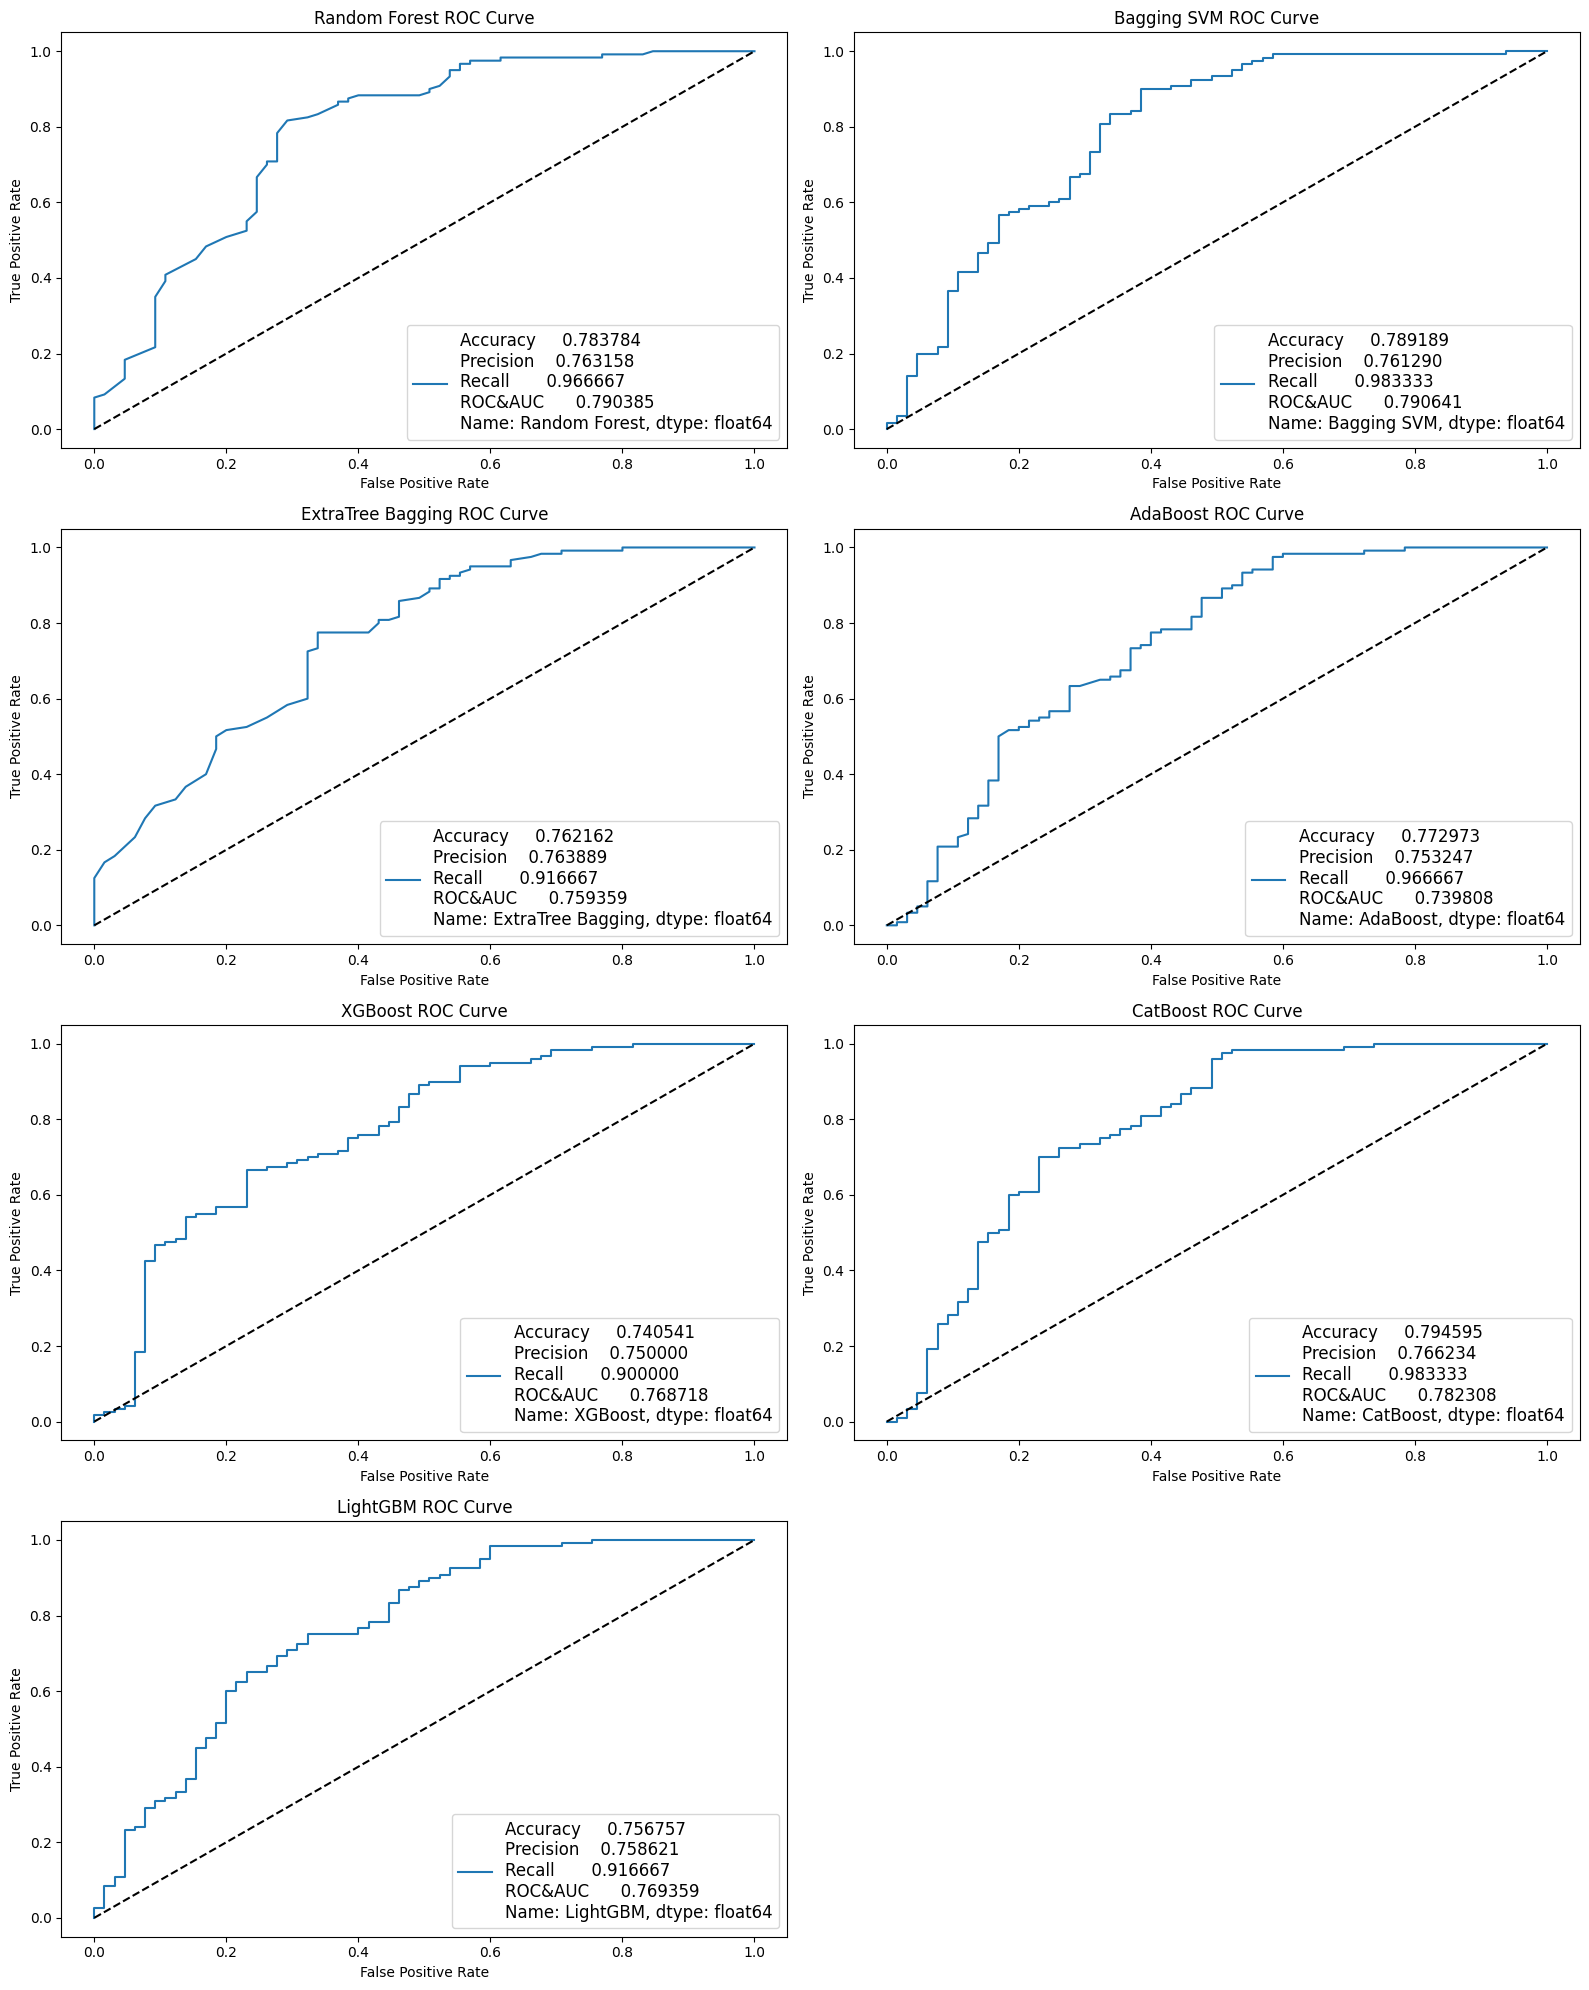

In [442]:
fig,axes = plt.subplots(nrows=4,ncols=2,figsize=(16,20))
axes = axes.flatten()

for i, model_dict in enumerate(final_plot_scores):
    for model, (fpr,tpr) in model_dict.items():
        axes[i].plot(fpr,tpr, label=f'{final_scores.iloc[:,i]}')
        axes[i].plot([0,1], [0,1], 'k--')
        axes[i].set_title(f'{model} ROC Curve')
        axes[i].set_xlabel('False Positive Rate')
        axes[i].set_ylabel('True Positive Rate')
        axes[i].legend(fontsize=12)

fig.delaxes(axes[7])
plt.tight_layout()
plt.show()

### Gini score

In [443]:
gini_scores = 2 * final_scores.loc['ROC&AUC'] - 1    # Gini score = AUC*2-1

In [444]:
final_scores.loc['Gini'] = gini_scores
final_scores

,Random Forest,Bagging SVM,ExtraTree Bagging,AdaBoost,XGBoost,CatBoost,LightGBM
Accuracy,0.783784,0.789189,0.762162,0.772973,0.740541,0.794595,0.756757
Precision,0.763158,0.761290,0.763889,0.753247,0.750000,0.766234,0.758621
Recall,0.966667,0.983333,0.916667,0.966667,0.900000,0.983333,0.916667
ROC&AUC,0.790385,0.790641,0.759359,0.739808,0.768718,0.782308,0.769359
Gini,0.580769,0.581282,0.518718,0.479615,0.537436,0.564615,0.538718


Now sort the algorithms based on the Gini score, to choose the best algorithm.

In [448]:
final_scores = final_scores.T.sort_values(by='Gini', ascending=False)
final_scores

,Accuracy,Precision,Recall,ROC&AUC,Gini
Bagging SVM,0.789189,0.761290,0.983333,0.790641,0.581282
Random Forest,0.783784,0.763158,0.966667,0.790385,0.580769
CatBoost,0.794595,0.766234,0.983333,0.782308,0.564615
LightGBM,0.756757,0.758621,0.916667,0.769359,0.538718
XGBoost,0.740541,0.750000,0.900000,0.768718,0.537436
ExtraTree Bagging,0.762162,0.763889,0.916667,0.759359,0.518718
AdaBoost,0.772973,0.753247,0.966667,0.739808,0.479615


## Summary

1. **Accuracy**: is best for **CatBoost**. It means number of correct predictions is maximum in this model.
2. **Precision**: highest for **CatBoost**. It shows how many positive predictions are actually correct.
3. **Recall**: highest for **Bagging SVM** and **CatBoost**. It shows how many actual positives are correctly identified.
4. **ROC&AUC**: highest for **Bagging SVM**. It shows the ability to separate the classes (trade-off between TPR and FPR).
5. **Gini**: highest for **Bagging SVM**. It also shows discriminative power of the model.

According to the overall results, Bagging SVM is best in terms of discriminating the target classes, but CatBoost performed the best in most of the evaluation metrics.